# Clustering

## 1. Setting up and Loading dataset

In [2]:
# Importing Libraries
import scanpy as sc
import anndata
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.sparse import csr_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

np.random.seed(223)

In [3]:
# Reading the dataset into python as an anndata
files_path = '../scHAMR/STARsolo_results/Solo.out/Gene/filtered_gzipped/'
# files_path = os.path.expanduser(files_path)
adata = sc.read_10x_mtx(files_path)

/home/myousry2002/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## 2. Data Cleaning and Quality Control

Define a function for quality control check using metrics and visualizations:

In [4]:
def data_quality_control_check(adata):
    """
    Perform quality control (QC) analysis on an AnnData object used in scRNA-seq data analysis.

    This function calculates and adds QC metrics to the AnnData object for each cell. These metrics include 
    the total counts of RNA molecules per cell, the number of detected genes, and the fraction of 
    mitochondrial (MT) genes. It also generates violin plots and scatter plots for these metrics to assist 
    in determining appropriate threshold values for further quality control filtering.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing scRNA-seq data. This object should have cells as rows and genes as columns.
    
    Returns:
    --------
    adata : AnnData
        The modified AnnData object with added QC metrics. The metrics added are 'n_genes_by_counts' (number of 
        genes detected in each cell), 'total_counts' (total number of RNA molecules detected per cell), and 
        'pct_counts_mt' (percentage of counts belonging to mitochondrial genes).
    """

    # Identify and annotate mitochondrial genes, which start with MT in their ID
    adata.var['mt'] = adata.var_names.str.startswith('MT-')

    # Calculate quality check metrics, particularly: total counts, no. of genes, and MT genes fraction
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
    
    # Produce a violin plot for the quality check metrics 
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
    
    # Produce scatter plots for total count vs mitochondrial genes and gene count
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    
    return adata

Define a function that applies selected quality control metrics:

In [5]:
def data_quality_control_apply(adata, min_counts, max_counts, min_genes, max_genes, max_pct_mt):
    
    """
    Apply a series of quality control filters to an AnnData object from scRNA-seq data.

    This function performs several filtering steps to remove low-quality cells based on specified 
    criteria: the maximum total counts, the minimum and maximum number of genes expressed, and the 
    maximum percentage of mitochondrial gene counts. The function prints the number of cells in the 
    dataset after each filtering step for tracking the impact of each criterion.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing single-cell RNA sequencing data, with cells as rows and genes as columns.
    max_counts : int
        Maximum allowed total counts (sum of all gene expression counts) per cell. Cells exceeding this 
        threshold will be filtered out.
    min_genes : int
        Minimum number of genes that must be expressed in a cell. Cells with fewer expressed genes will 
        be filtered out.
    max_genes : int
        Maximum number of genes that must be expressed in a cell. Cells with more expressed genes will 
        be filtered out.
    max_pct_mt : float
        Maximum allowed percentage of mitochondrial gene counts. Cells with a higher percentage will be 
        filtered out.

    Returns:
    --------
    AnnData
        The filtered AnnData object.
    """
    
    # Number of cells before any filtering
    print('Total number of cells before filtering: {:d}'.format(adata.n_obs))
    
    # Filter out counts over min_counts
    sc.pp.filter_cells(adata, min_counts = min_counts)
    print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
    
    # Filter out counts over max_counts
    sc.pp.filter_cells(adata, max_counts = max_counts)
    print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

    # Filter out cells with under min_genes genes
    sc.pp.filter_cells(adata, min_genes = min_genes)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

    #Filter out cells with over max_genes genes
    sc.pp.filter_cells(adata, max_genes = max_genes)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
    
    # Filter out cells with high percentage of mitochondrial genes
    #adata = adata[adata.obs.pct_counts_mt < max_pct_mt, :].copy()
    adata = adata[adata.obs['pct_counts_mt'] < max_pct_mt].copy()

    print('Number of cells after MT pct filter: {:d}'.format(adata.n_obs))
    
    return adata

Applying the data cleaning functions:

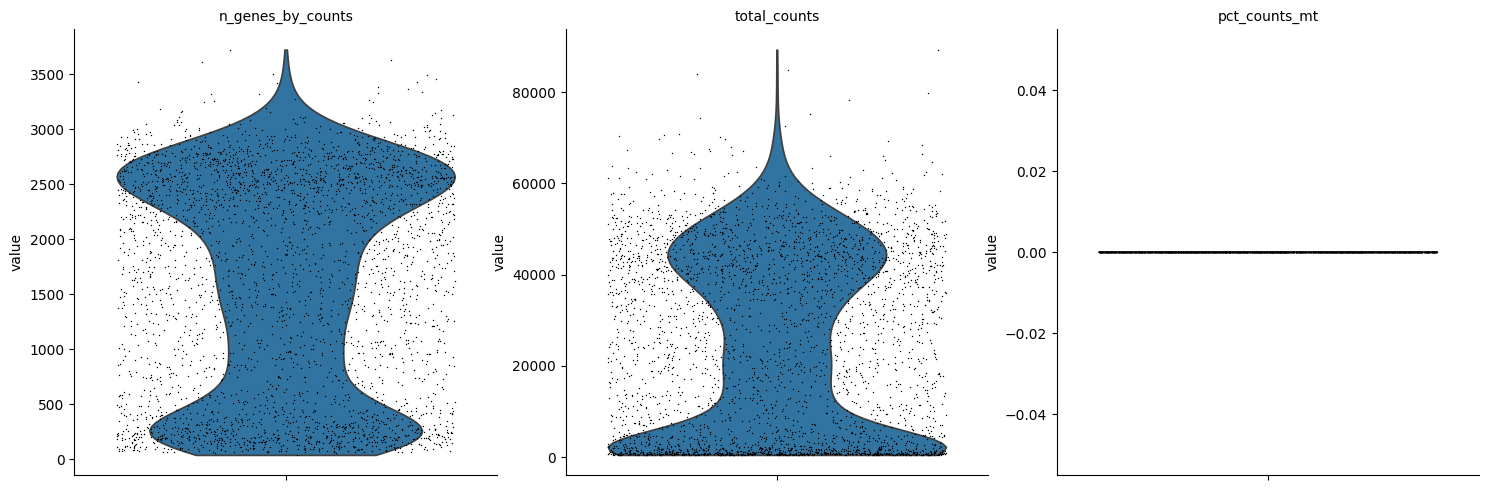

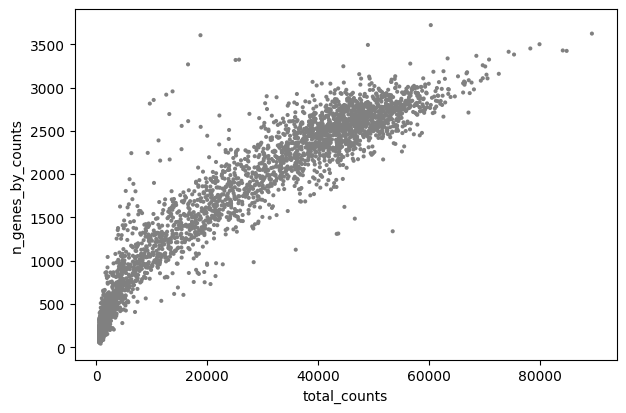

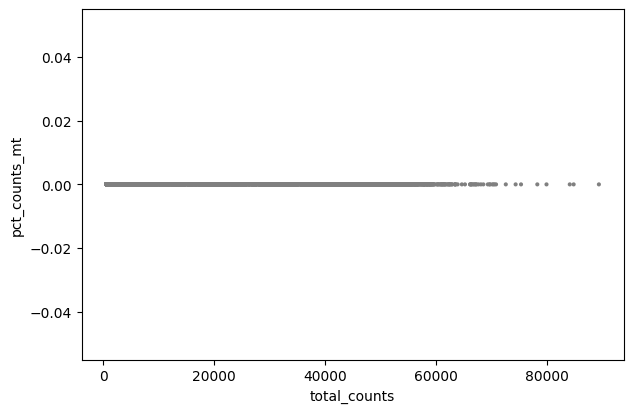

AnnData object with n_obs × n_vars = 3442 × 13986
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
# Calculate and visualize QC metrics
data_quality_control_check(adata)

In [7]:
# Apply selected QC values
adata = data_quality_control_apply(adata, min_counts=200, max_counts=70000, min_genes=100, max_genes=5000, max_pct_mt=2)

Total number of cells before filtering: 3442
Number of cells after min count filter: 3442
Number of cells after max count filter: 3430
Number of cells after gene filter: 3351
Number of cells after gene filter: 3351
Number of cells after MT pct filter: 3351


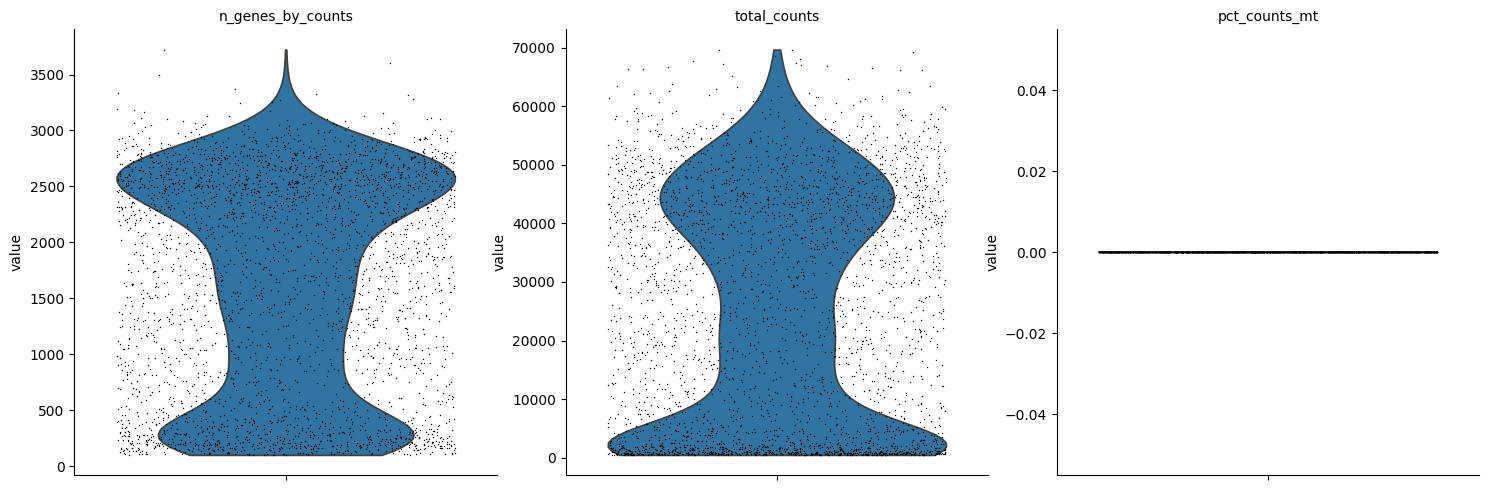

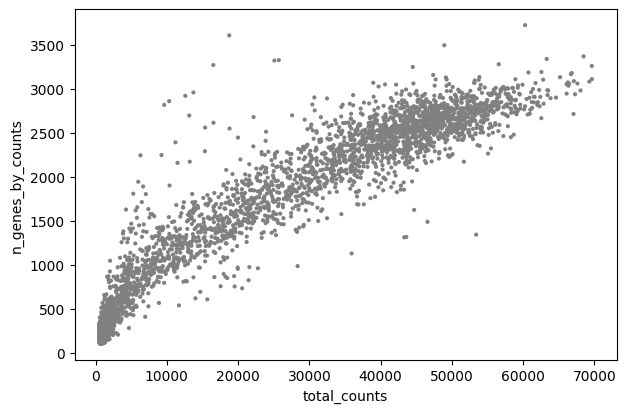

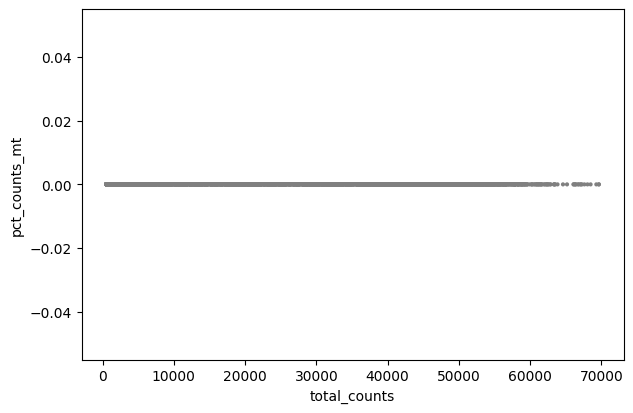

AnnData object with n_obs × n_vars = 3351 × 13986
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [8]:
# Calculate and visualize QC metrics after applying QC
data_quality_control_check(adata)

Filtering out genes expressed in less than X cells in the whole dataset. Those genes are probably artifacts:

In [9]:
# Filter genes
print('Total number of genes: {:d}'.format(adata.n_vars))

# Basic filtering - a Gene must be at least detected in 30 cells
sc.pp.filter_genes(adata, min_cells=30)

print('Number of genes after filtering: {:d}'.format(adata.n_vars))

Total number of genes: 13986
Number of genes after filtering: 6804


## 3. Data Transformation

Normalizing

In [10]:
# Keep the count data that is not normalized in a counts layer.
adata.layers["counts"] = adata.X.copy()

# Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell.
sc.pp.normalize_total(adata, target_sum=1e4)

Logarithmizing

In [11]:
# Logarithmize the data
sc.pp.log1p(adata)

# Save the normalized and logarithmized raw data in the .raw attribute of the anndata.
adata.raw = adata

## 4. Extracting Highly Variable Genes (HVGs) and Further Cleaning

Highly variable genes analysis

/home/myousry2002/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


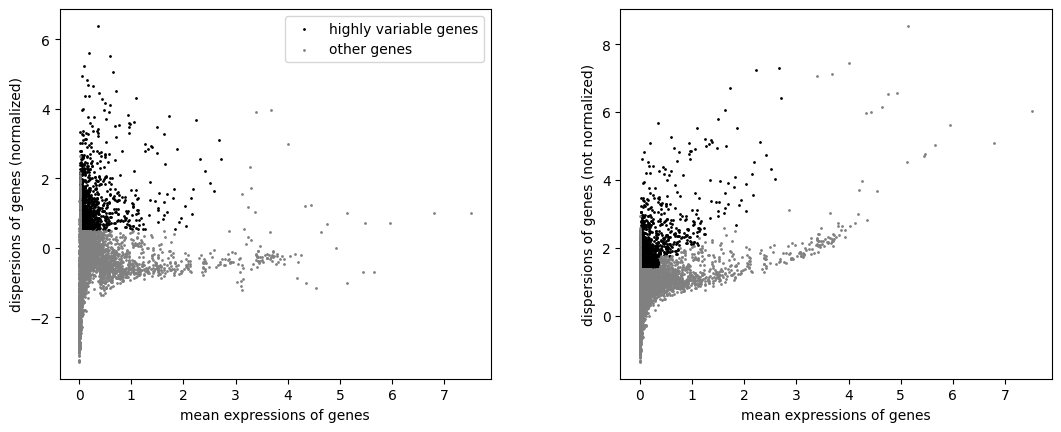

In [12]:
# Extracting highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Visualization of highly variable genes
sc.pl.highly_variable_genes(adata)

# Get only highly variable genes
adata = adata[:, adata.var.highly_variable]

Regress out the effects of confounding variables, such as total count and mitochondrial genes percentage

In [13]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

Scaling the data to unit variance and clip values above standard deviation of 10 to minimize the effects of the outliers

In [14]:
sc.pp.scale(adata, max_value=10)

## 5. Principal Component Analysis (PCA)

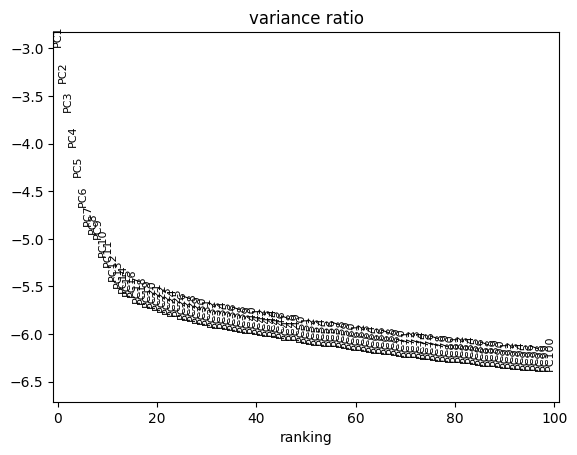

In [15]:
# Performing Principal Component Analysis (PCA)
sc.tl.pca(adata, n_comps=100, svd_solver='arpack')

# Visualize elbow plot for the variance ratio across principal components
sc.pl.pca_variance_ratio(adata, n_pcs=100, log=True)

## 6. Neighborhood Graph Construction

In [16]:
# Calculate the neighborhood graph with 50 PCs. 
sc.pp.neighbors(adata, n_pcs=50, n_neighbors = 15)

/home/myousry2002/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 7.  Uniform Manifold Approximation and Projection (UMAP)

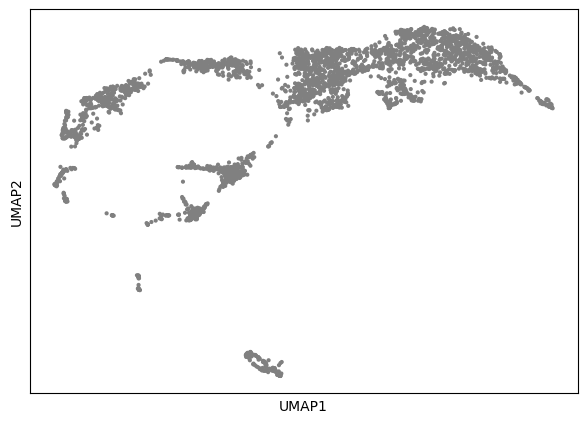

In [17]:
# UMAP calculation
sc.tl.umap(adata, min_dist = 0.02)

# Visualize the UMAP with highlighting the different five samples in the dataset
sc.pl.scatter(adata, basis='umap')

# 8. Clustering

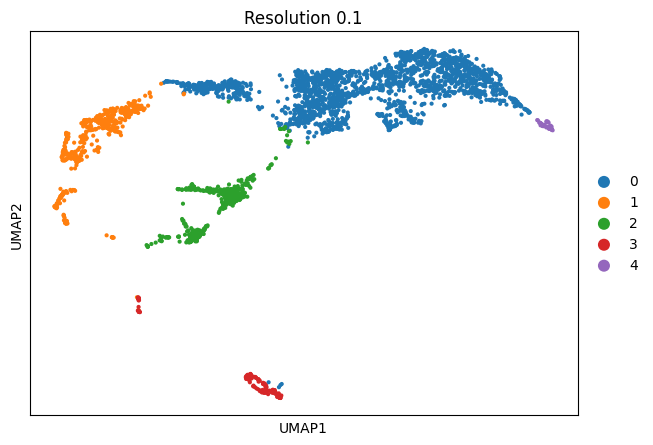

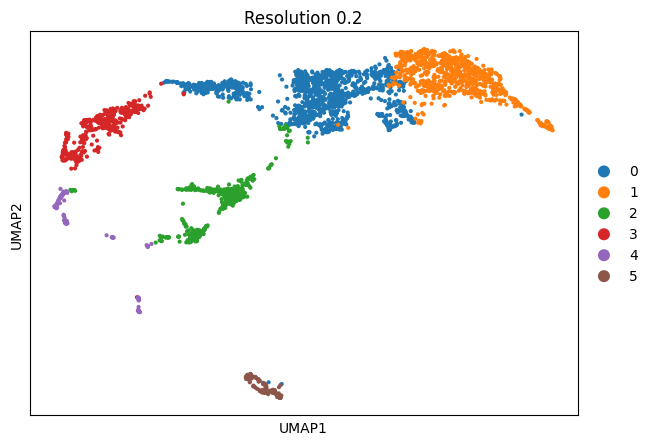

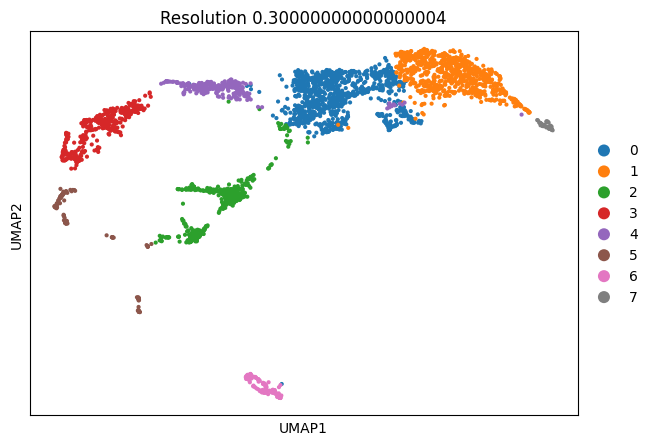

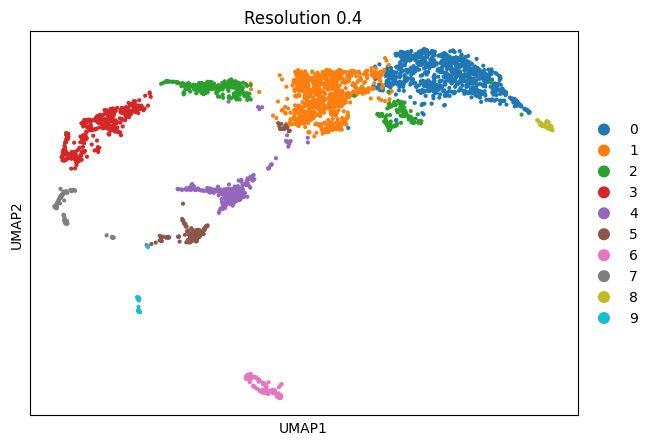

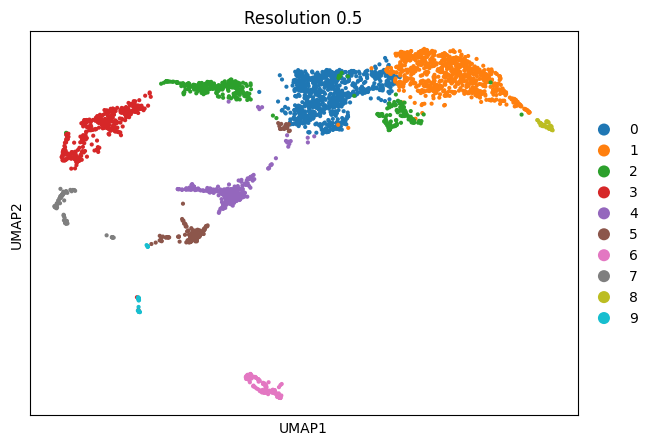

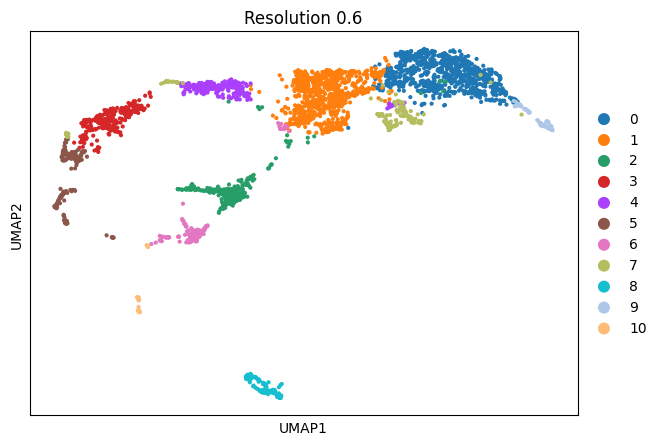

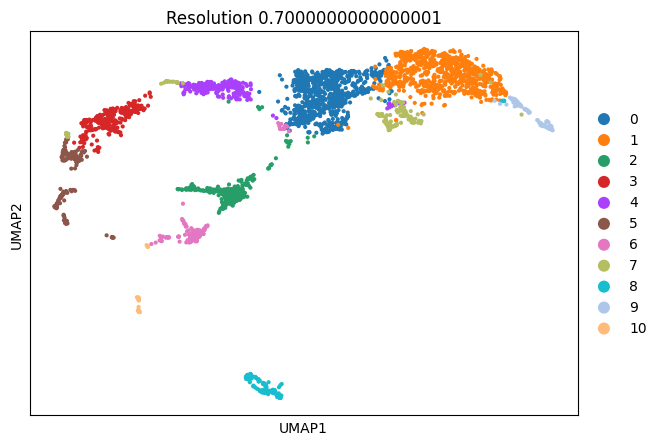

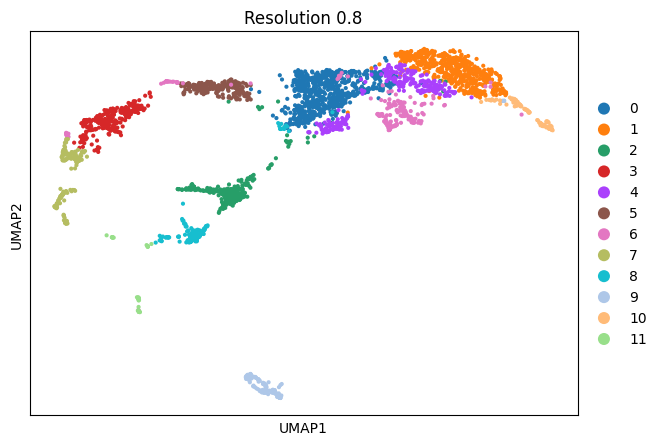

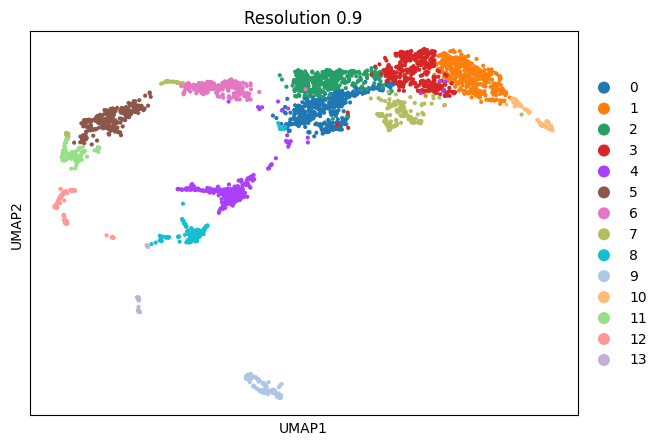

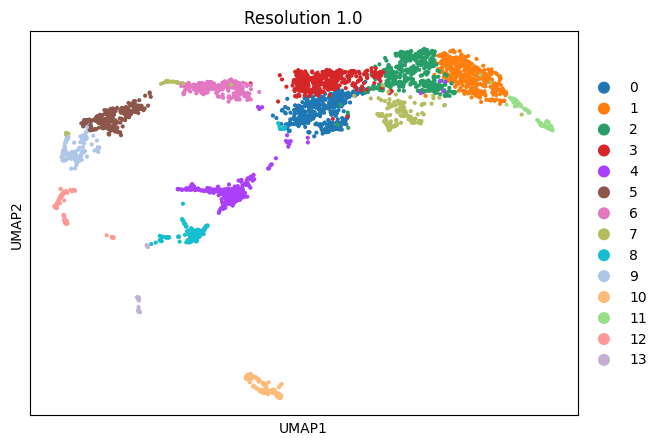

In [18]:
# Define a range of resolution values
resolutions = np.arange(0.1, 1.1, 0.1)  

# Initialize dictionaries to store scores
silhouette_scores = {}
davies_bouldin_scores = {}
calinski_harabasz_scores = {}

for res in resolutions:
    # Perform Louvain clustering at the given resolution
    sc.tl.leiden(adata, resolution=res, key_added=f'clustering_{res}')

    # Retrieve the cluster labels
    labels = adata.obs[f'clustering_{res}']

    # Assuming adata.obsm['X_pca'] contains the PCA reduced data
    X_pca = adata.obsm['X_pca']

    # Calculate Silhouette Score
    silhouette_scores[res] = silhouette_score(X_pca, labels)

    # Calculate Davies-Bouldin Score
    davies_bouldin_scores[res] = davies_bouldin_score(X_pca, labels)

    # Calculate Calinski-Harabasz Score
    calinski_harabasz_scores[res] = calinski_harabasz_score(X_pca, labels)

    # Plot the clusters
    sc.pl.scatter(adata, basis='umap', color=f'clustering_{res}', title=f'Resolution {res}')

Inspect the statistical metrics and plot them against resolution parameters:

Silhouette Scores: {0.1: 0.07668788, 0.2: 0.04014135, 0.30000000000000004: 0.041786324, 0.4: 0.033062827, 0.5: 0.03687433, 0.6: 0.02298073, 0.7000000000000001: 0.027321247, 0.8: -0.01291855, 0.9: -0.026625764, 1.0: -0.02025623}
Davies-Bouldin Scores: {0.1: 2.1332704936046962, 0.2: 2.4486506817114546, 0.30000000000000004: 2.459900531204196, 0.4: 2.330676953217309, 0.5: 2.344203334655832, 0.6: 2.3770131876651623, 0.7000000000000001: 2.4005153496375256, 0.8: 2.675920012401729, 0.9: 2.824800178724535, 1.0: 2.809256382761743}
Calinski-Harabasz Scores: {0.1: 211.02971303637221, 0.2: 151.99192146755206, 0.30000000000000004: 161.09829558381605, 0.4: 141.20311903394125, 0.5: 141.20963867351378, 0.6: 125.9826009996398, 0.7000000000000001: 121.9621464843818, 0.8: 108.94454842050115, 0.9: 101.12451601367574, 1.0: 101.4839825474074}


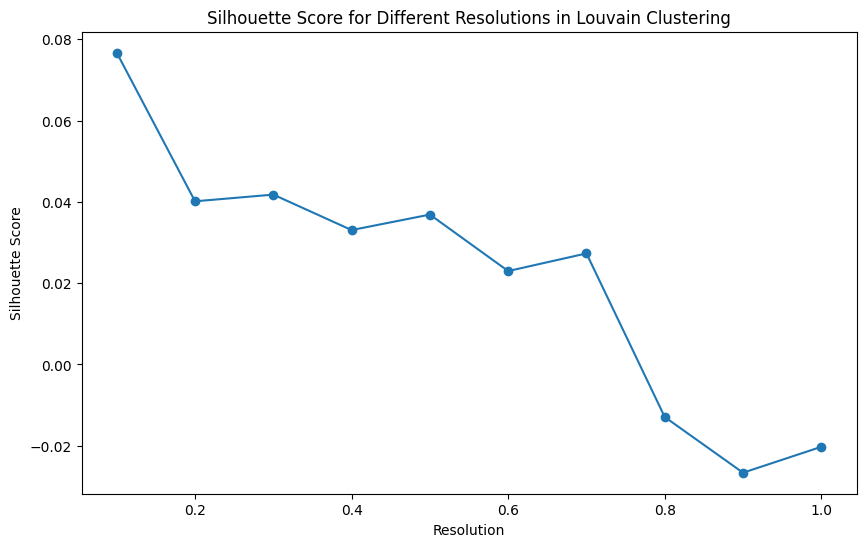

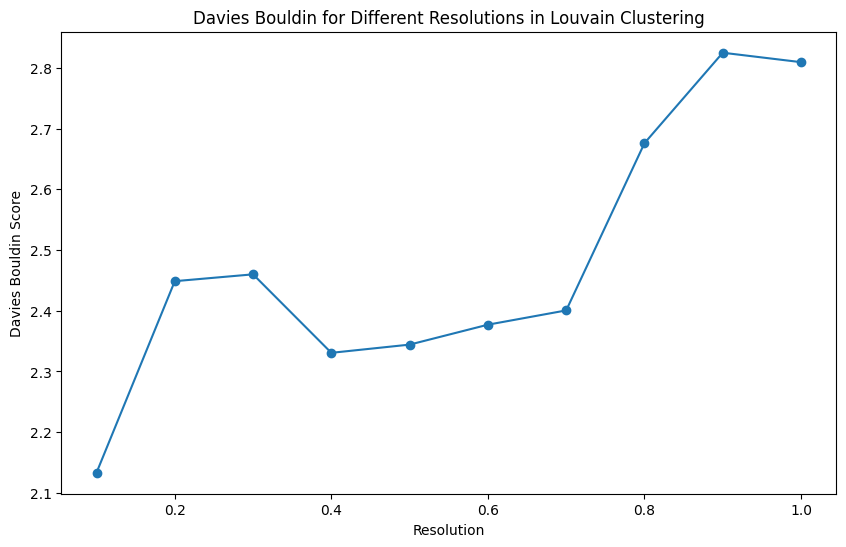

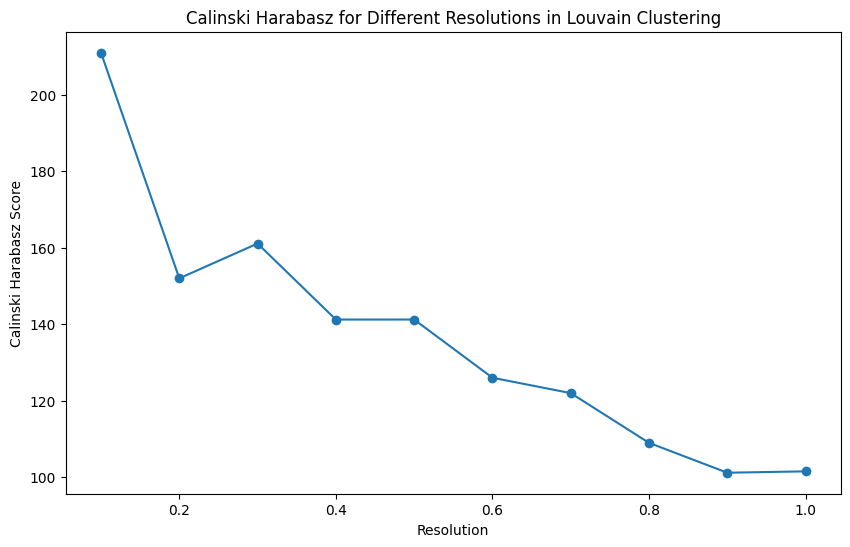

In [23]:
# Inspect the scores in the dictionaries
print("Silhouette Scores:", silhouette_scores)
print("Davies-Bouldin Scores:", davies_bouldin_scores)
print("Calinski-Harabasz Scores:", calinski_harabasz_scores)

# Plotting Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Resolutions in Louvain Clustering")
plt.show()

# Plotting Davies Bouldin Score
plt.figure(figsize=(10, 6))
plt.plot(list(davies_bouldin_scores.keys()), list(davies_bouldin_scores.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Davies Bouldin Score")
plt.title("Davies Bouldin for Different Resolutions in Louvain Clustering")
plt.show()

# Plotting Calinski Harabasz Score
plt.figure(figsize=(10, 6))
plt.plot(list(calinski_harabasz_scores.keys()), list(calinski_harabasz_scores.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Calinski Harabasz Score")
plt.title("Calinski Harabasz for Different Resolutions in Louvain Clustering")
plt.show()

After deciding on a resolution parameter, visualize the clustering results

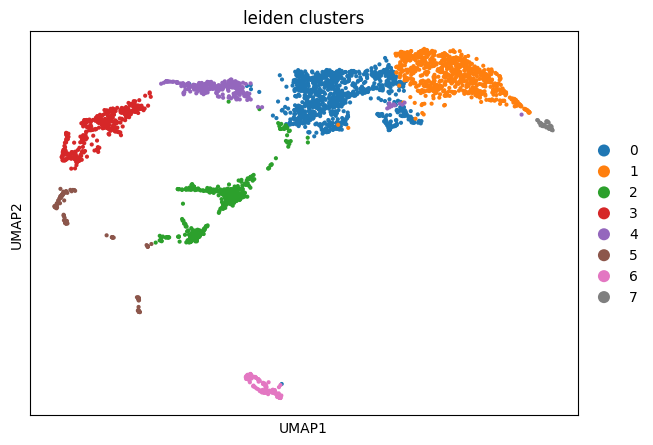

Silhouette score:  0.041786324
Davies Bouldin score:  2.459900531204196
Calinski Harabasz score:  161.09829558381605


In [25]:
sc.tl.leiden(adata, key_added= 'leiden_clusters', resolution=0.3)
sc.pl.scatter(adata, basis='umap', color=['leiden_clusters'])

labels = adata.obs['leiden_clusters']
X_pca = adata.obsm['X_pca']

# Calculate Silhouette Score
silhouette_score_value_leiden = silhouette_score(X_pca, labels)
print("Silhouette score: ", silhouette_score_value_leiden)

# Calculate Davies-Bouldin Score
davies_bouldin_score_value_leiden = davies_bouldin_score(X_pca, labels)
print("Davies Bouldin score: ",  davies_bouldin_score_value_leiden)

# Calculate Calinski-Harabasz Score
calinski_harabasz_score_value_leiden = calinski_harabasz_score(X_pca, labels)
print("Calinski Harabasz score: ", calinski_harabasz_score_value_leiden)

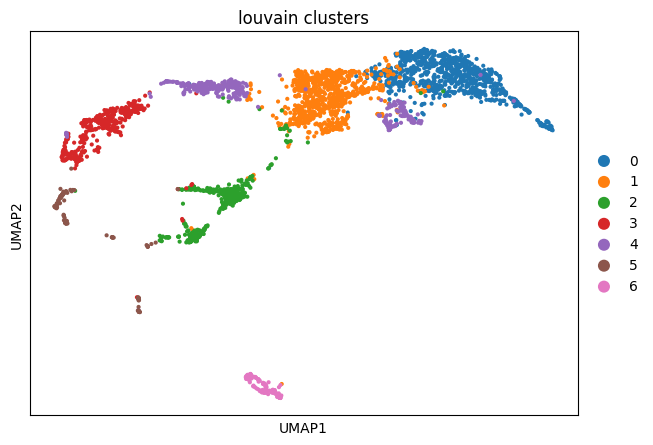

Silhouette score:  -0.011776353
Davies Bouldin score:  2.5224331545818854
Calinski Harabasz score:  132.31021376166936


In [21]:
sc.tl.louvain(adata, key_added= 'louvain_clusters', resolution=0.3)
sc.pl.scatter(adata, basis='umap', color=['louvain_clusters'])

labels = adata.obs['louvain_clusters']
X_pca = adata.obsm['X_pca']

# Calculate Silhouette Score
silhouette_score_value_leiden = silhouette_score(X_pca, labels)
print("Silhouette score: ", silhouette_score_value_leiden)

# Calculate Davies-Bouldin Score
davies_bouldin_score_value_leiden = davies_bouldin_score(X_pca, labels)
print("Davies Bouldin score: ",  davies_bouldin_score_value_leiden)

# Calculate Calinski-Harabasz Score
calinski_harabasz_score_value_leiden = calinski_harabasz_score(X_pca, labels)
print("Calinski Harabasz score: ", calinski_harabasz_score_value_leiden)

## 9. Exporting a Dataframe for Cell Barcodes and Clusters ID

In [61]:
# Extracting cell barcodes and cluster IDs
cell_barcodes = adata.obs_names
cluster_ids = adata.obs['leiden_clusters']

# Creating a dataframe
cb_cluster_df = pd.DataFrame({'CellBarcode': cell_barcodes, 'ClusterID': cluster_ids})

# Saving the dataframe to CSV
csv_file_path = "../scHAMR/clustering/CBs_Clusters_dataframe.csv"  # Adjust the path as needed
cb_cluster_df.to_csv(csv_file_path, index=False)